In [1]:
import jax
from jax import numpy as np
from jax import scipy as sp
from jax import random

from numpy.polynomial.hermite import hermgauss

import scipy.cluster.hierarchy as sch

import paragami

# GMM libraries
import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
from bnpgmm_runjingdev import gmm_posterior_quantities_lib
from bnpgmm_runjingdev import utils_lib

# BNP libraries
from bnpmodeling_runjingdev import result_loading_utils

# wrapper to load results
from gmm_loading_utils import GMMResultsLoader

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp 
onp.random.seed(53453)

# Load data

In [3]:
# load iris data
iris_obs, iris_species = utils_lib.load_iris_data()
dim = iris_obs.shape[1]
n_obs = len(iris_species)

iris_obs = np.array(iris_obs)

Text(0, 0.5, 'PC2')

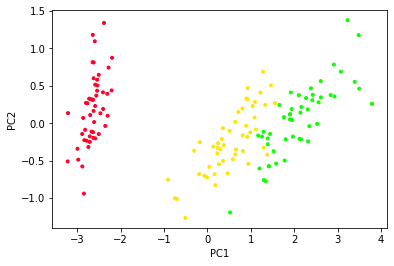

In [4]:
# run PCA
pca_fit = PCA()
pca_fit.fit(iris_obs)
pc_iris_obs = pca_fit.transform(iris_obs)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_iris_obs[:, 0], pc_iris_obs[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Load fits

In [5]:
out_folder = '../fits/'
out_filename = 'iris_fit'

In [6]:
alpha0 = 6.0

In [7]:
gmm_result_loader = GMMResultsLoader(alpha0, 
                                     out_folder, 
                                     out_filename)

loading initial fit from:  ../fits/iris_fit_alpha6.0.npz
loading lr derivatives from:  ../fits/iris_fit_alpha6.0_lrderivatives.npz


### Some meta data and model parameters

In [8]:
vb_init_free = gmm_result_loader.vb_init_free
vb_params_paragami = gmm_result_loader.vb_params_paragami
vb_init_dict = vb_params_paragami.fold(vb_init_free, free = True)

In [9]:
# gauss-hermite parameters
gh_deg = int(gmm_result_loader.init_fit_meta_data['gh_deg'])
gh_loc, gh_weights = hermgauss(gh_deg)

gh_loc = np.array(gh_loc)
gh_weights = np.array(gh_weights)
    
# load prior parameters
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)

# set initial alpha
assert alpha0 == gmm_result_loader.init_fit_meta_data['dp_prior_alpha']
prior_params_dict['dp_prior_alpha'] = alpha0

print(prior_params_dict)

{'dp_prior_alpha': 6.0, 'prior_centroid_mean': DeviceArray([0.], dtype=float64), 'prior_lambda': DeviceArray([1.], dtype=float64), 'prior_wishart_df': DeviceArray([10.], dtype=float64), 'prior_wishart_rate': DeviceArray([[1., 0., 0., 0.],
             [0., 1., 0., 0.],
             [0., 0., 1., 0.],
             [0., 0., 0., 1.]], dtype=float64)}


### Initial ezs

In [11]:
ez_init = gmm_posterior_quantities_lib.get_optimal_z_from_vb_dict(iris_obs,
                                            vb_init_dict,
                                            gh_loc,
                                            gh_weights,
                                            use_bnp_prior = True)

# for better plotting later, cluster the ez's
link = sch.linkage(ez_init, method='average')
ez_perm = sch.dendrogram(link, no_plot=True)["leaves"]

### Plot initial fit

In [12]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_params_dict['cluster_params']['cluster_info']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]
    
    utils_lib.plot_clusters(pc_iris_obs[:, 0], 
                            pc_iris_obs[:, 1],
                            bnp_clusters, 
                            colors1, fig, 
                            centroids = bnp_centroids_pc[np.unique(bnp_clusters), :], 
                            cov = bnp_cluster_covs_pc[np.unique(bnp_clusters), :, :])


Text(0, 0.5, 'PC2')

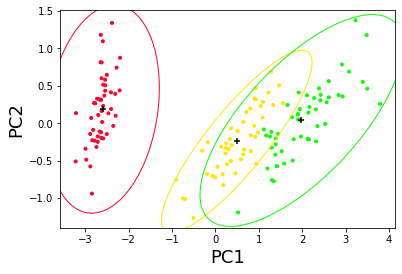

In [13]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_init_dict, ez_init, fig)

fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


# Functions to plot results

### Function to get optimal ez

In [14]:
def get_ez_opt(vb_free_params): 
    
    # this returns the expected individual mixture proportions. 
        
    vb_params_dict = vb_params_paragami.fold(vb_free_params, 
                                             free = True)
    
    ez = gmm_posterior_quantities_lib.get_optimal_z_from_vb_dict(iris_obs,
                                            vb_params_dict,
                                            gh_loc,
                                            gh_weights,
                                            use_bnp_prior = True)
    
    return ez

### plot co-clustering and diffs

In [15]:
def plot_coclustering(ez_refit, ez_lr, ez_init): 
    
    fig, ax = plt.subplots(1, 4, figsize = (16, 3))
    
    # compute co-clustering matrices
    
    # the init
    coclust_init = np.dot(ez_init, 
                          ez_init.transpose())
    
    # the refit
    coclust_refit = np.dot(ez_refit,
                           ez_refit.transpose())
    
    # the lr
    coclust_lr = np.dot(ez_lr,
                        ez_lr.transpose())
    
    # plot diff colormaps
    result_loading_utils.plot_colormaps(coclust_refit,
                                        coclust_lr,
                                        coclust_init,
                                        fig, ax[2:], 
                                        plot_initial = False)
    
    # plot diff in expected individual belongings
    result_loading_utils.print_diff_plot(ez_refit.flatten(), 
                                         ez_lr.flatten(),
                                         ez_init.flatten(), 
                                         ax[0],
                                         alpha = 0.05)
    
    
    # plot diff in coclustering
    result_loading_utils.print_diff_plot(coclust_refit.flatten(), 
                                         coclust_lr.flatten(),
                                         coclust_init.flatten(), 
                                         ax[1],
                                         alpha = 0.05)
    
    
    return fig, ax

In [16]:
@jax.jit
def get_diff_in_ez(vb_free): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    ez_pert = get_ez_opt(vb_free)
    
    ez_init = get_ez_opt(vb_init_free)
    
    return np.abs(ez_pert - ez_init).mean()

@jax.jit
def get_diff_in_coclustering(vb_free): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    ez_pert = get_ez_opt(vb_free)
    coclust_matr = np.dot(ez_pert, ez_pert.transpose())
    
    ez_init = get_ez_opt(vb_init_free)
    coclust_matr0 = np.dot(ez_init, ez_init.transpose())
    
    return np.abs(coclust_matr - coclust_matr0).mean()

### wrapper to plot results for a given perturbation

In [17]:
def plot_results_for_perturbation(perturbation, delta, epsilon_indx_vec = [-1]): 
    
    #################
    # load free parameters
    #################
    vb_refit_list, lr_list, epsilon_vec = \
        gmm_result_loader.get_free_param_results_from_perturbation(perturbation, delta)
    assert (vb_refit_list[0] == lr_list[0]).all()
    
    #################
    # see how our summary statistic changes
    #################
    fig, ax = plt.subplots(1, 3, figsize = (12, 3))
    result_loading_utils.plot_post_stat_per_epsilon(get_diff_in_ez, 
                                                    vb_refit_list,
                                                    lr_list,
                                                    epsilon_vec,
                                                    ax[0])
    ax[0].set_ylabel('median. abs. error in ez')
    
    result_loading_utils.plot_post_stat_per_epsilon(get_diff_in_coclustering, 
                                                    vb_refit_list,
                                                    lr_list,
                                                    epsilon_vec,
                                                    ax[1])
    ax[1].set_ylabel('median. abs. error in coclust')
    ax[0].legend()
    
    for a in ax: 
        for eps_indx in epsilon_indx_vec: 
            a.axvline(epsilon_vec[eps_indx],
                       color = 'grey',
                       linestyle = 'dashed')
    fig.tight_layout()
    
    ###############
    # initial ez and coclustering
    ###############
    ez_init = get_ez_opt(vb_refit_list[0])[ez_perm]
    coclust_init = np.dot(ez_init, ez_init.transpose())
    ax[2].set_title('initial coclustering')
    im0 = ax[2].matshow(coclust_init, 
                        cmap = plt.get_cmap('Blues'))
    fig.colorbar(im0, ax = ax[2])

    for eps_indx in epsilon_indx_vec: 
        #################
        # get ezs
        #################
        ez_refit = get_ez_opt(vb_refit_list[eps_indx])[ez_perm]
        ez_lr = get_ez_opt(lr_list[eps_indx])[ez_perm]

        #####################
        # plot co-clustering
        #####################
        fig, ax = plot_coclustering(ez_refit, ez_lr, ez_init)
        ax[0].set_title('diff in ez; epsilon = {:.03f}'.format(epsilon_vec[eps_indx]))
        ax[1].set_title('diff in coclust; epsilon = {:.03f}'.format(epsilon_vec[eps_indx]))
    
        fig.tight_layout()

# Sigmoidal perturbations

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 9.388126e-08
  warnings.warn(


Optim time at epsilon = 1: 1.644secs
Derivative time: 0.020secs


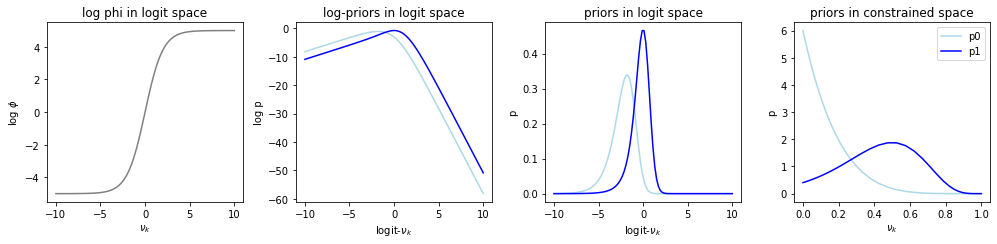

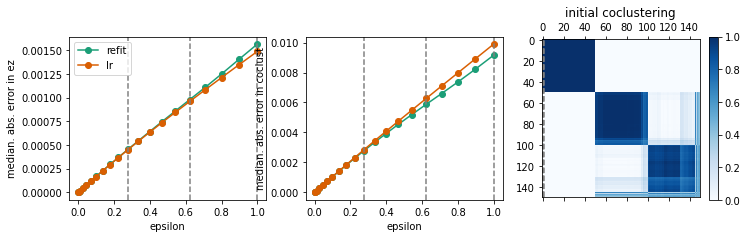

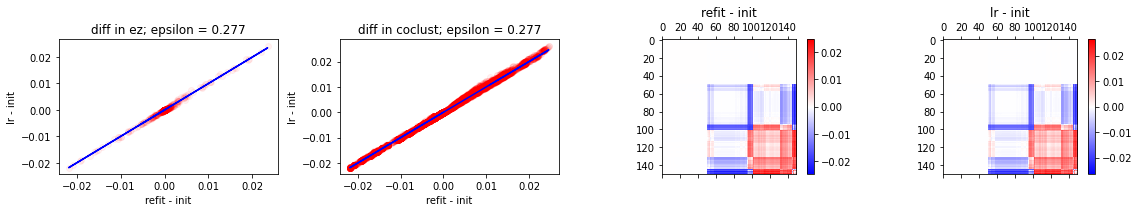

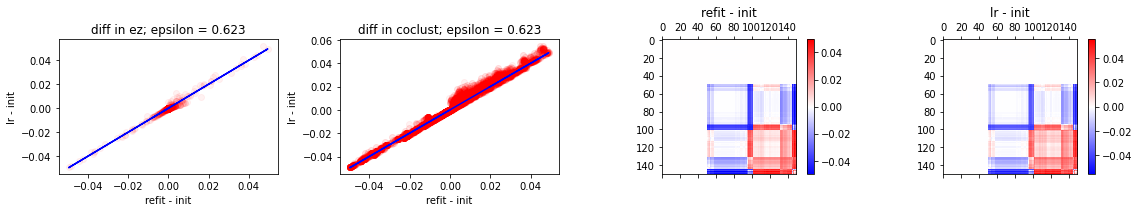

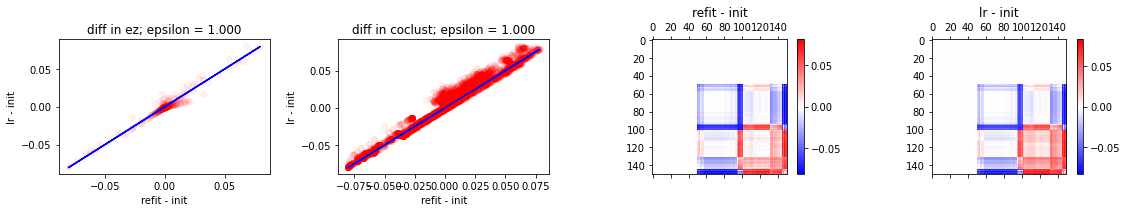

In [18]:
delta = 5
perturbation = 'sigmoidal'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1])

Optim time at epsilon = 1: 1.659secs
Derivative time: 0.020secs


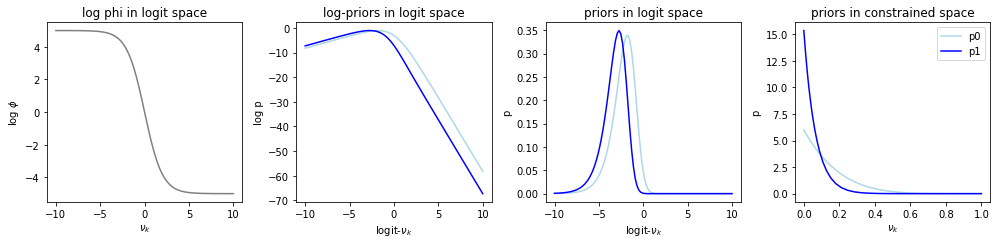

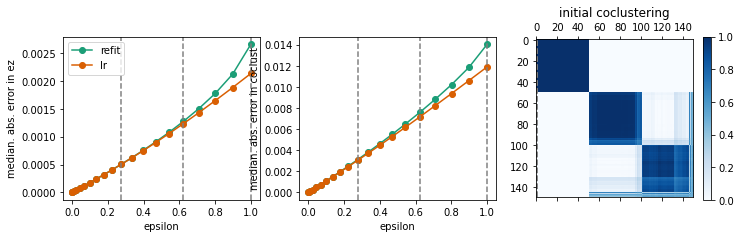

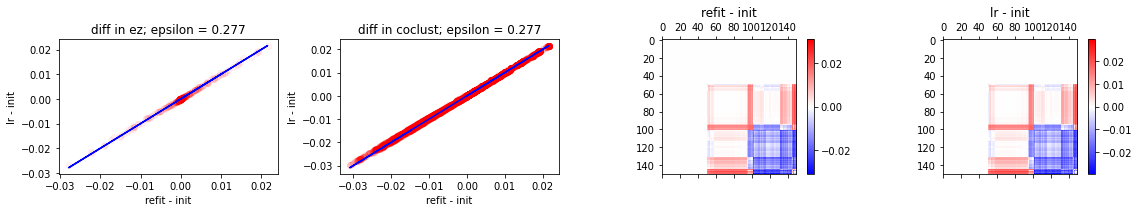

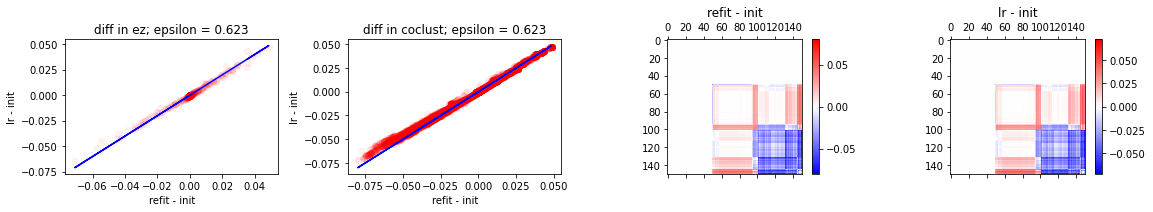

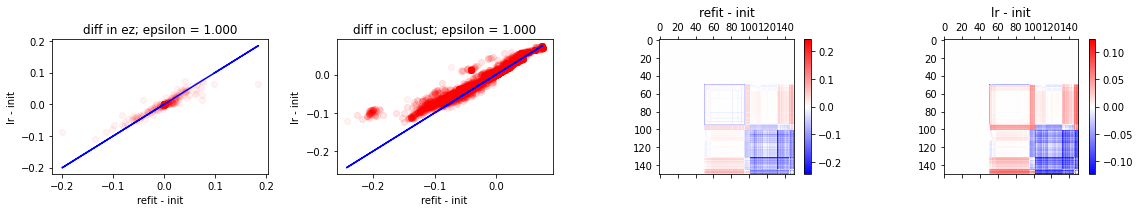

In [19]:
delta = -5
perturbation = 'sigmoidal'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1])

# Alpha-type perturbations

Optim time at epsilon = 1: 1.804secs
Derivative time: 0.021secs


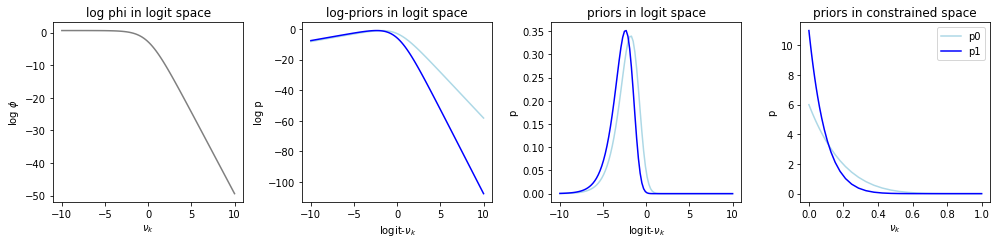

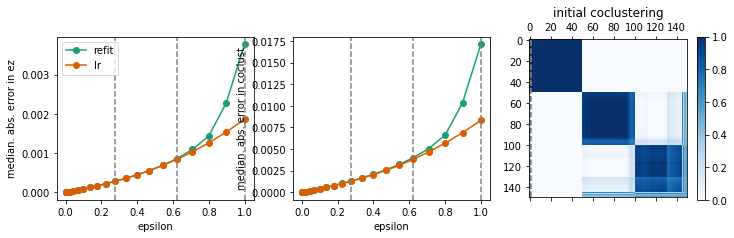

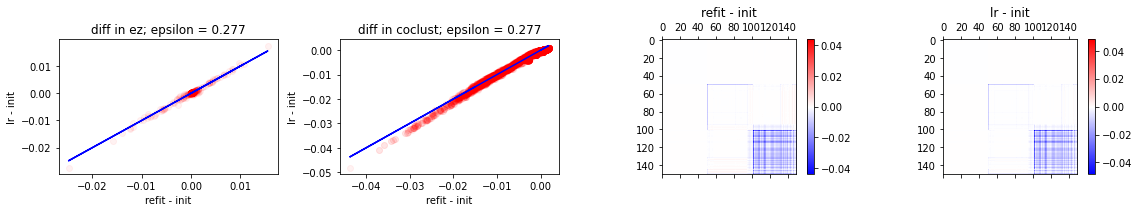

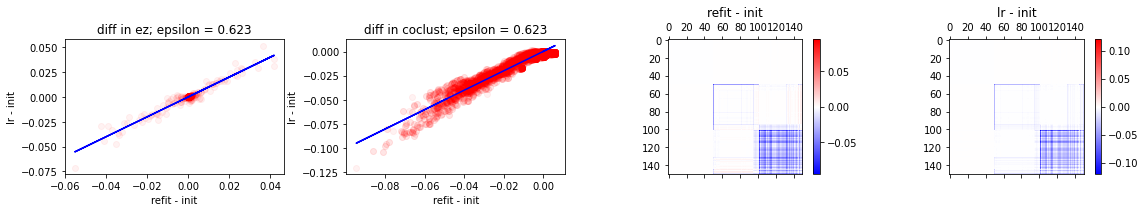

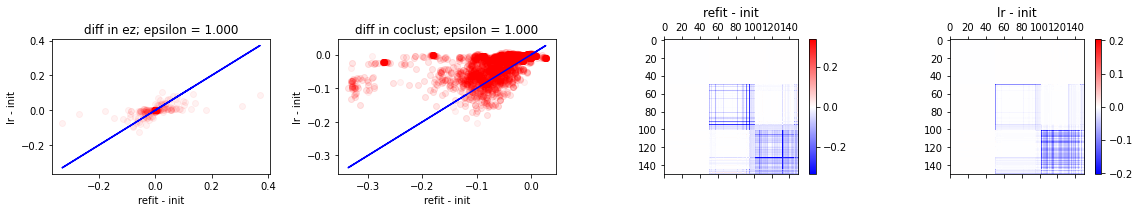

In [20]:
delta = 1
perturbation = 'alpha_pert_pos'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1])

Optim time at epsilon = 1: 1.631secs
Derivative time: 0.016secs


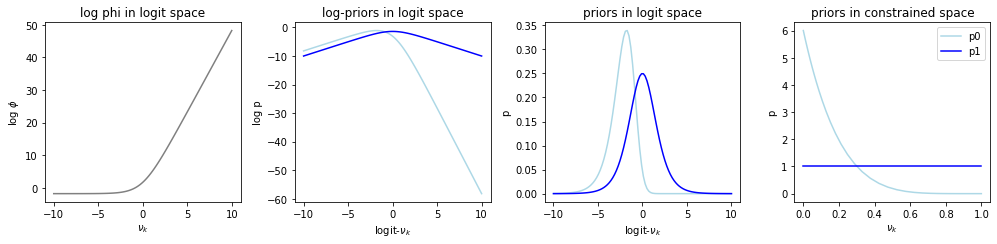

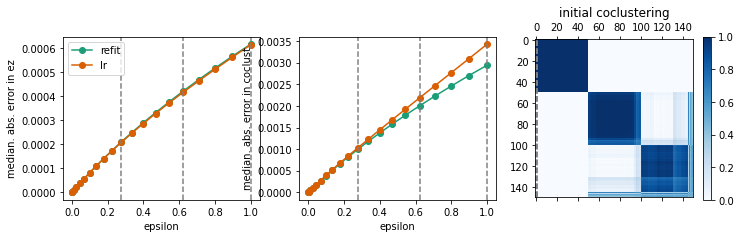

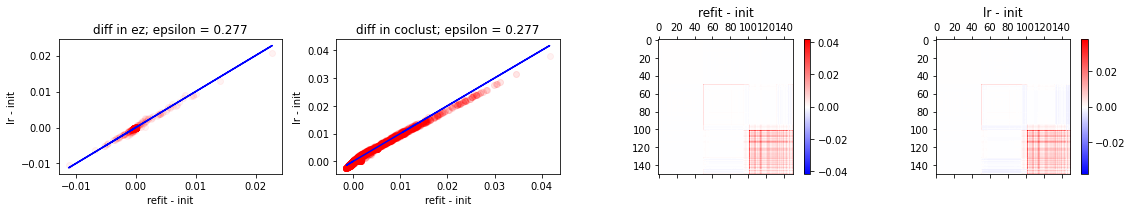

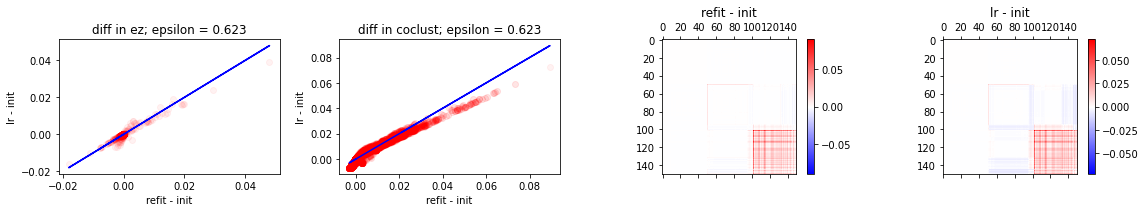

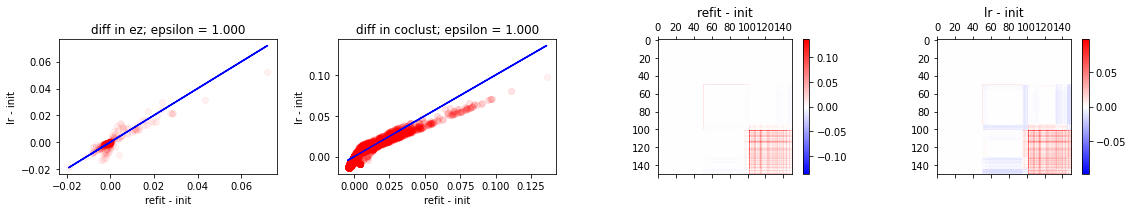

In [21]:
delta = 1
perturbation = 'alpha_pert_neg'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1])

# Gaussian bumps

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.362176e-04
  warnings.warn(


Optim time at epsilon = 1: 1.584secs
Derivative time: 0.016secs


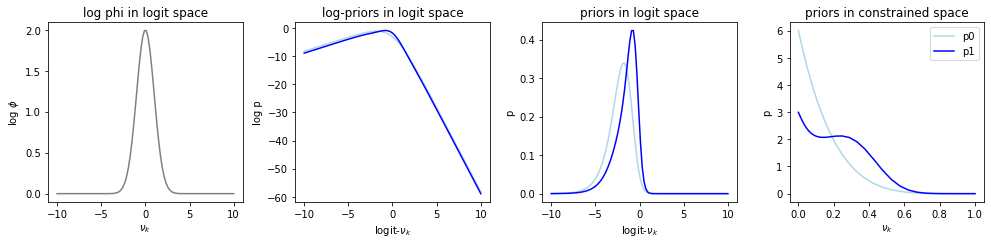

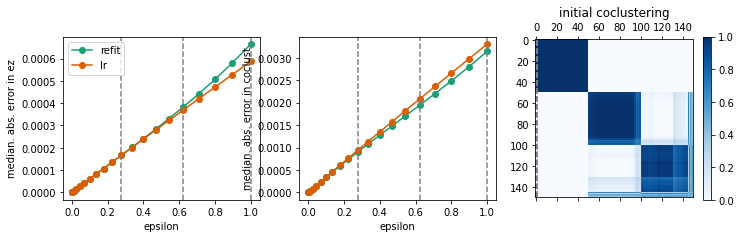

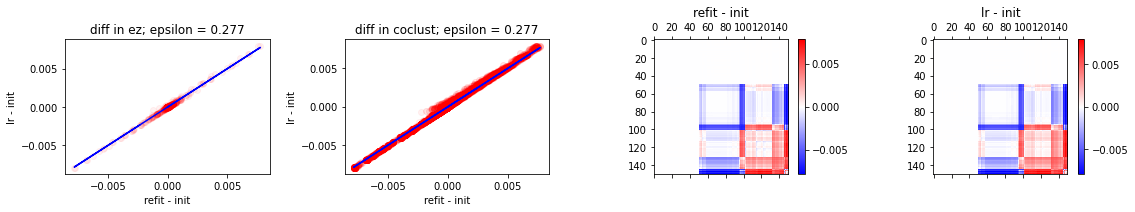

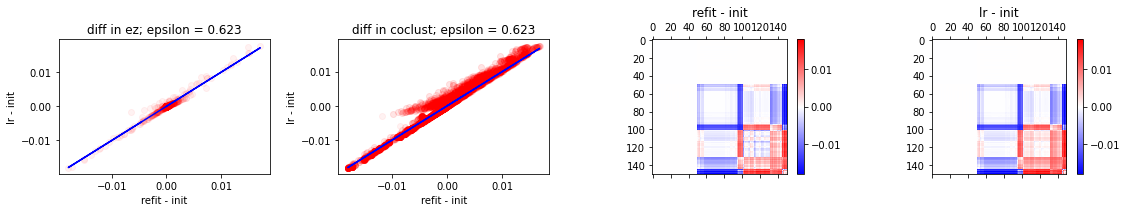

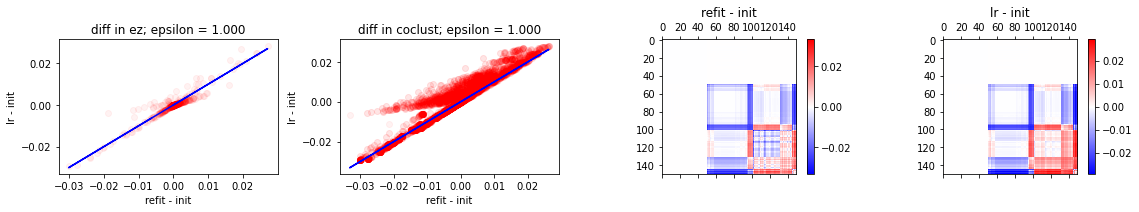

In [22]:
delta = 2
perturbation = 'gauss_pert1'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1])

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.070934e-06
  warnings.warn(


Optim time at epsilon = 1: 1.525secs
Derivative time: 0.016secs


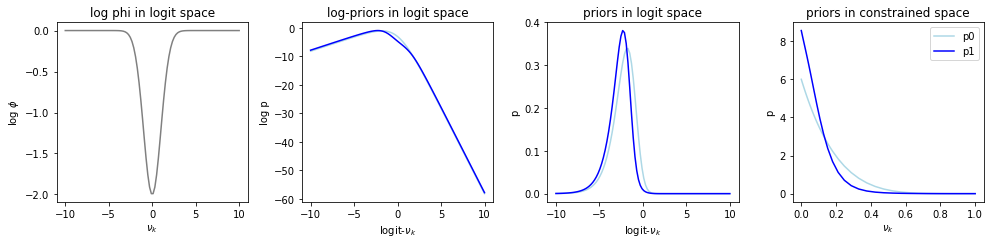

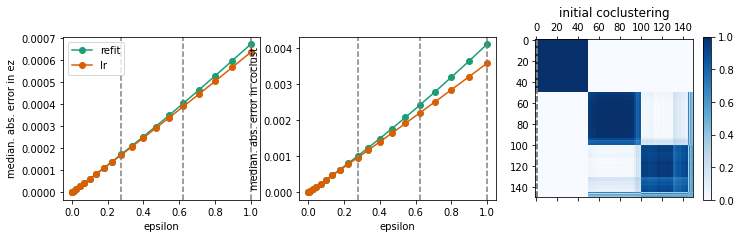

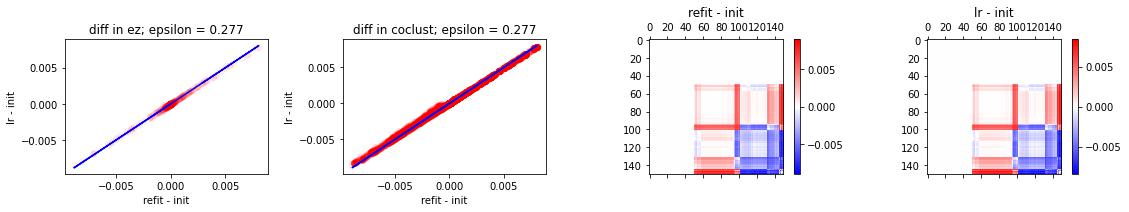

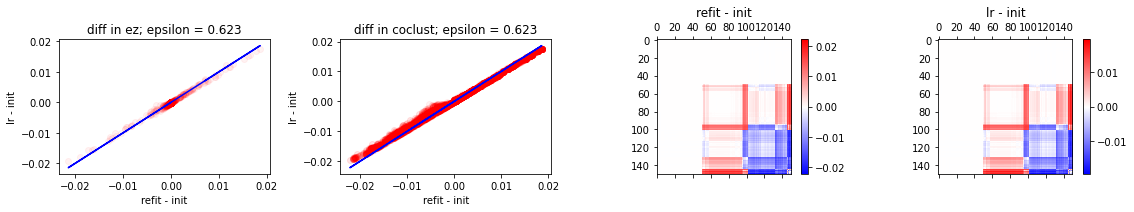

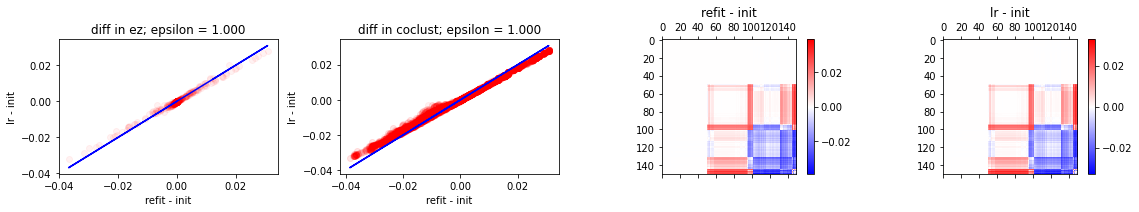

In [23]:
delta = -2
perturbation = 'gauss_pert1'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1])

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 4.091173e-05
  warnings.warn(


Optim time at epsilon = 1: 1.208secs
Derivative time: 0.015secs


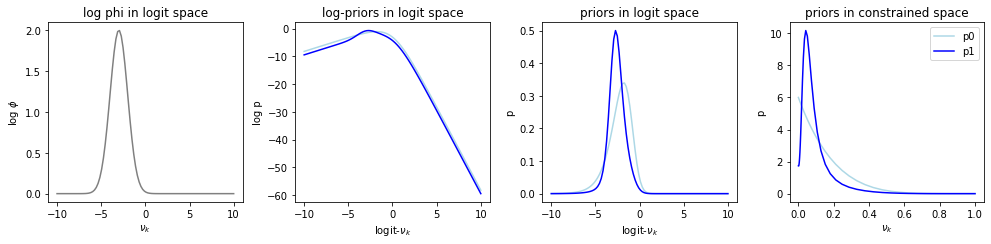

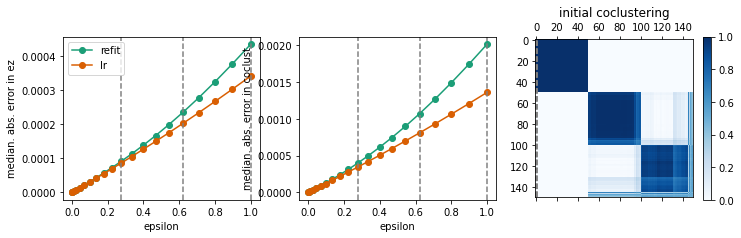

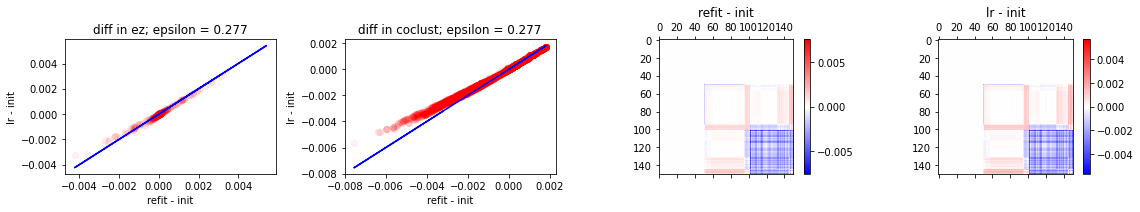

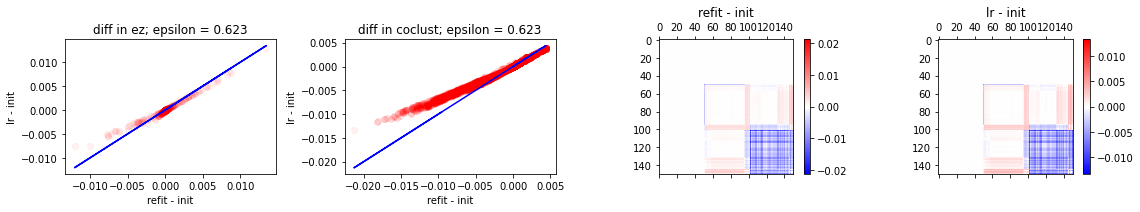

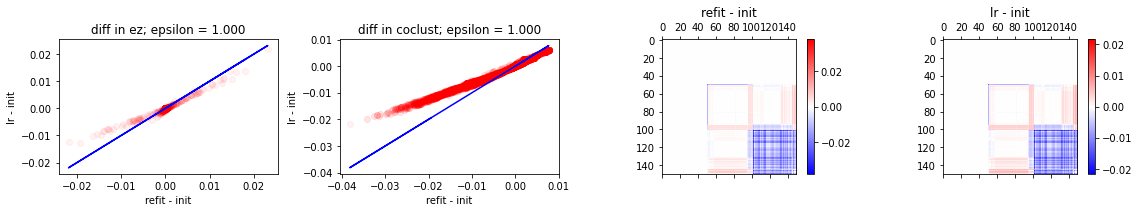

In [24]:
delta = 2
perturbation = 'gauss_pert2'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1])

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.327195e-07
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 9.136652e-07
  warnings.warn(


Optim time at epsilon = 1: 1.447secs
Derivative time: 0.015secs


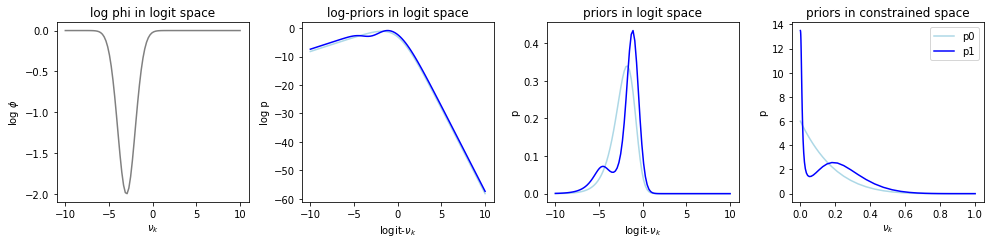

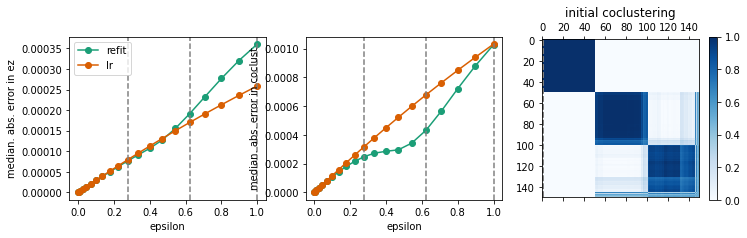

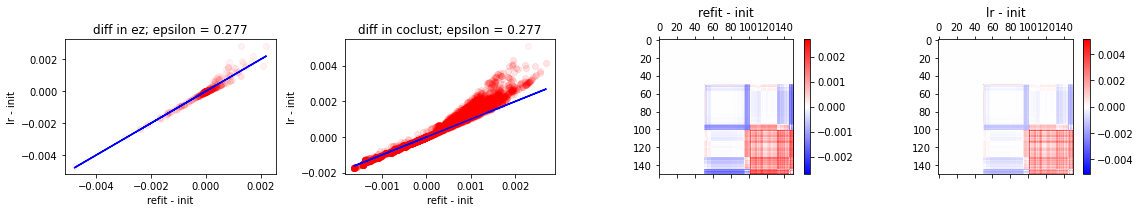

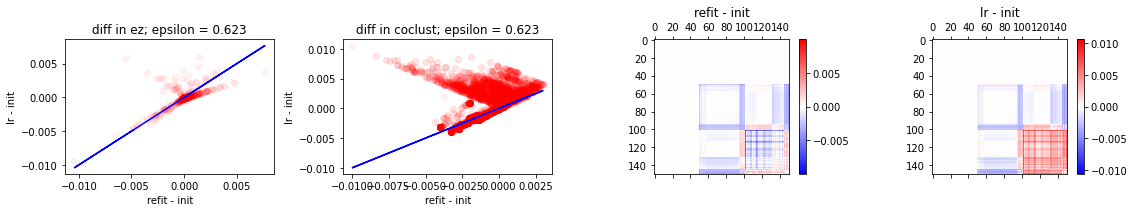

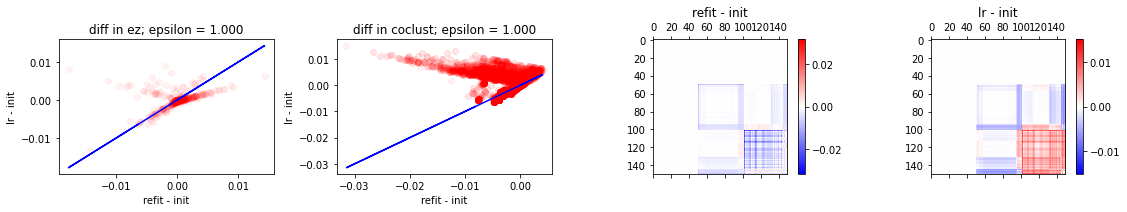

In [25]:
delta = -2
perturbation = 'gauss_pert2'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1])